This tutorial aims at implementing the paper $\href{https://openreview.net/forum?id=V5kCKFav9j}{\textit{A Sinkhorn-type Algorithm for Constrained Optimal Transport}}$. The main contribution was the implementation of such algorithm. The algorithm uses an entropic regularization and adds a few elements in order to respect linear constraints. 

Constrained OT problems can be described in a general form as : 

$r = \text{target},\; c = \text{source}$ and $\sum_{i=1}^n r_i = \sum_{i=1}^n c_i = 1$

We denote by K and L the number of inequality and equality constraints. We can find $D_1,...,D_K,D_{K+1},...,D_L \in \mathbb{R}^{n\times n}$ in order to define any constraints of the form $D\cdot P \geq t$. Such matrices and encoded by $\mathcal{I}$ and $\mathcal{E}$ with $\mathcal{I}, \mathcal{E}$ with : 
$$ \mathcal{I} := \bigcap_{k=1,...,K}\{ P | D_k \cdot P \geq 0\}, \quad \mathcal{E} := \bigcap_{l=1,...,L}\{P | D_{l+K}\cdot P \geq 0 \}$$ 

We have an inquality with $0$ as we can convert the conditions $D\cdot P \geq t$ into $(D - t \textbf{1}_{n\times n})\cdot P \geq 0$.

### Imports

In [1]:
import jax
import numpy as np
from jax import grad
import jax.numpy as jnp
import numpy as np
import ott
from tqdm import tqdm
import seaborn as sns
import optax
from jax import tree_util
import matplotlib.pyplot as plt

## Setup for gaussian source and target with random uniform constraints and costs

Implementation for a 1D optimal transport problem. We will set the target as a Gaussian distribution and the source as a mixture of Gaussian distributions. The costs will be random as well as the inequalities. The authors of the papers refer to this as 'random assignment'.

$n = 30, \; \eta = 50, \;\text{and}\; C,D_I,D_E \in \mathbb{R}^{n\times n}$. 

The entries of $C,D_I,D_E \sim \mathcal{U}([0,1])$. The entries of C are however modified in order to see if the algorithm runs smoothly.

Two threshold variables $t_I,t_E$. We set them as $t_I = t_E = \frac{1}{2}$

We consider the following optimization problem : 

$$ \min_{P : P\textbf{1}=r, P^T\textbf{1}=c} \quad \quad C \cdot P $$
$$\text{subject to : } D_I\cdot P \leq t_I, \; D_E \cdot P = t_E$$ 

In order to be able to use the general form we can use :

$$D1 = (D_I - t_I \textbf{1}_{n\times n})/n \quad \text{and} \quad D_2 = (D_E - t_E \textbf{1}_{n\times n})/n$$

In [2]:
n = 30
eta = 50
N = 40 #set to 40 as in the paper the convergence is reached after 40 iterations.
one = jnp.ones((n,1))
key1, key2, key3 = jax.random.split(jax.random.key(0), 3)


c1 = 0.5*(jnp.ones((int(n/2),1))*4 + jax.random.normal(key=key1, shape=(int(n/2),1))*0.6)
c2 = 0.5*(jnp.ones((int(n/2),1))*8 + jax.random.normal(key=key3, shape=(int(n/2),1))*0.2)#source
c = jnp.vstack([c1,c2])
r = -jnp.ones((n,1))*3 + jax.random.normal(key=key2, shape=(n,1))*0.3 #target
c /= jnp.sum(c)
r /= jnp.sum(r)
c = jnp.sort(c)
r = jnp.sort(r)

C = np.random.uniform(low=0., high=1, size=(n,n))
for i in range(n):
    for j in range(n):
        if i and j > int(n/2):
            C[i,j] *= 1.5
        else :
            C[i,j] *= 0.5
C = jnp.array(C)


DI = jax.random.uniform(key=key2, minval=0., maxval=1., shape=(n, n))
DE = jax.random.uniform(key=key3, minval=0., maxval=1., shape=(n, n))
tI = 1/2
tE = 1/2
D1 = (DI - tI*one@one.T)/n
D2 = (DE - tE*one@one.T)/n

### Visualization of the costs, the source and the target densities

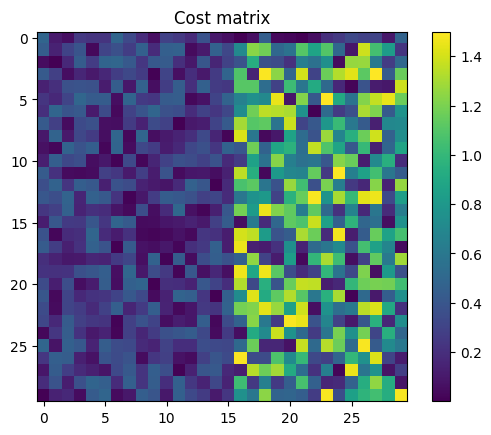

In [3]:
plt.title('Cost matrix')
plt.imshow(C)
plt.colorbar()

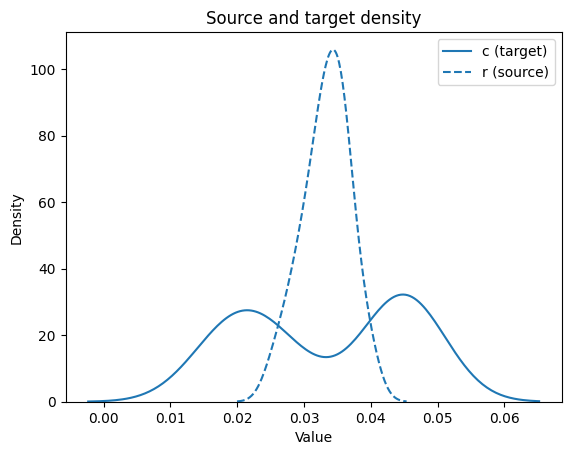

In [4]:
sns.kdeplot(np.array(c), linestyle='-', label='c (target)', legend=False)
sns.kdeplot(np.array(r), linestyle='--', label='r (source)', legend=False)

plt.legend()  
plt.title("Source and target density")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

As it is of main importance for the algorithm we recall here the definition of the Lyapounov function $f$ : 

$$f(x,y,a) = \underbrace{-\frac{1}{\eta}\sum_{ij}\exp\left(\eta(-C_{ij} + \sum_{m=1}^{K+L}a_m(D_m)_{i,j} + x_i +y_j) -1  \right)}_{(1)} + \underbrace{\sum_i x_i r_i + \sum_j y_j c_j}_{(2)} - \underbrace{\frac{1}{\eta}\sum_{k=1}^K\exp(-\eta a_k -1)}_{(3)}$$

In [5]:
def f(x,y,a):
    """
    dual potential function

    -------------------------------------------
    parameters:


    x : jnp array, of shape (n,1)
    dual variable

    y : jnp array, of shape (n,1)
    dual variable

    a : jnp array, of shape (K+L,1)
    constraint dual variables (excluding original constraints on rows and columns)

    -----------------------------------------------

    returns:

    output : real number, value of the min of the lagrangian

    """
    #to keep a vectorized procedure for autodiff
    first = jnp.array([1,0])
    first.reshape(2,1)
    second = jnp.array([0,1])
    second.reshape(2,1)
    
    a_0 = first.T@a
    a_1 = second.T@a
    sum_m = a_0*D1 + a_1*D2

    exponent = eta * (-C + sum_m + x + y.T) - 1
    exp_all = jnp.exp(jnp.clip(exponent, -40.0, 40.0))
    first_term = - (1 / eta) * jnp.sum(exp_all)

    second_term = x.T @ r + y.T @ c  

    exp_a0 = jnp.exp(jnp.clip(-eta * a_0 - 1, -40.0, 40.0))  
    exp_a1 = jnp.exp(jnp.clip(-eta * a_1 - 1, -40.0, 40.0))  
    third_term = - (1 / eta) * (exp_a0 + exp_a1)  

    
    output = first_term + second_term + third_term
    return output

In [6]:
#we define these functions in order to facilitate the following optimization steps
def f_at(a_t, x_bis, y):
    """
    makes modifications in order to optimize on the correct parameters in a conveninent and vectorized way
    """
    a_vec, t_scalar = jnp.split(a_t, [2])
    a_vec = a_vec.reshape(-1, 1)
    t_scalar = t_scalar[0]
    x_shifted = x_bis + t_scalar * jnp.ones_like(x_bis)
    return f(x_shifted, y, a_vec)[0, 0]
    
@jax.jit
def loss_fn(params, x, y):
    """
    computes the loss
    """
    return -f_at(params, x, y)

# Main algorithm

In [7]:
#initialization of the parameters 
x = jax.random.uniform(key=key2, minval=0., maxval=0.2, shape=(n, 1))
y = jax.random.uniform(key=key3, minval=0., maxval=0.1, shape=(n, 1))
key_a = jax.random.PRNGKey(0)
a = 1e-4 * jax.random.normal(key_a, (2, 1))
t = jnp.array(1e-3)

#definition of the optimizer
lr_schedule = optax.exponential_decay(
    init_value=1e-5,
    transition_steps=400,
    decay_rate=0.99,
    staircase=True
)
optimizer = optax.adam(learning_rate=lr_schedule)
a_t = jnp.concatenate([a.flatten(), jnp.array([t])])
opt_state = optimizer.init(a_t)
clip_value = 100.0


for i in tqdm(range(N)):
    # row and columns scaling
    first = jnp.array([1, 0]).reshape(2, 1)
    second = jnp.array([0, 1]).reshape(2, 1)
    a_0 = first.T @ a
    a_1 = second.T @ a
    sum_m = a_0 * D1 + a_1 * D2
    exp_input = jnp.clip(eta * (-C + sum_m + x @ one.T + y @ one.T) - 1, -40.0, 40.0)
    P = jnp.exp(exp_input)
    P = jnp.clip(P, a_min=1e-10)
    x += (jnp.log(jnp.clip(r, a_min=1e-10)) - jnp.log(jnp.clip(P @ one, a_min=1e-10))) / eta
    exp_input = jnp.clip(eta * (-C + sum_m + x @ one.T + y @ one.T) - 1, -40.0, 40.0)
    P = jnp.exp(exp_input)
    P = jnp.clip(P, a_min=1e-10)
    y += (jnp.log(jnp.clip(c, a_min=1e-10)) - jnp.log(jnp.clip(P @ one, a_min=1e-10))) / eta


    
    # optimization in order to find the argmax on f(x+t1, y, a)
    params0 = jnp.concatenate([x.flatten(), a.flatten()])
    y_fixed = y.copy()
    a_t = jnp.concatenate([a.flatten(), jnp.array([t])])
    opt_state = optimizer.init(a_t)
    for _ in range(500):
        loss_val, grads = jax.value_and_grad(loss_fn)(a_t, x, y)
        
        # clip gradients for numerical stability
        grads = tree_util.tree_map(lambda g: jnp.clip(g, -clip_value, clip_value), grads)
        
        updates, opt_state = optimizer.update(grads, opt_state)
        a_t = optax.apply_updates(a_t, updates)

    # updates
    a, t = jnp.split(a_t, [2])
    a = a.reshape(-1, 1)
    t = t[0]
    x += t * jnp.ones_like(x)



100%|██████████| 40/40 [02:02<00:00,  3.07s/it]


In [8]:
exp_input = jnp.clip(eta * (-C + sum_m + x@one.T + one@y.T) - 1, -40.0, 40.0)
P_final = jnp.exp(exp_input)

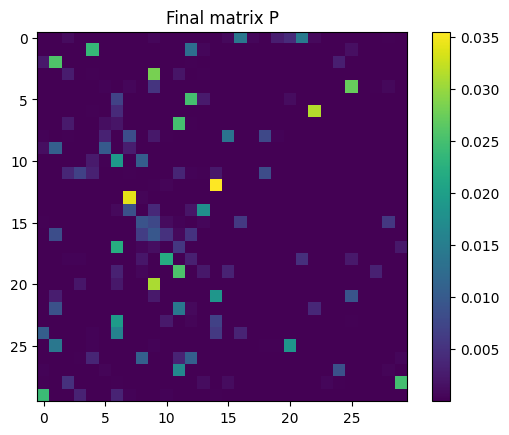

In [9]:
plt.title('Final matrix P')
plt.imshow(P)
plt.colorbar()
plt.show()

In [10]:
row_sums = jnp.sum(P, axis=1)  
col_sums = jnp.sum(P, axis=0)  


row_diff = row_sums - r.flatten()
col_diff = col_sums - c.flatten()


print("max row sum error:", jnp.max(jnp.abs(row_diff)))
print("max column sum error:", jnp.max(jnp.abs(col_diff)))

max row sum error: 6.444752e-05
max column sum error: 0.07707647


In [11]:
jnp.sum(P)

Array(0.99900997, dtype=float32)

We can notice that the constraints on P are (almost) verified, showing a good performance of the algorithm after 40 iterations. 

In [12]:
def visualize_transport_1d(x_src, x_tgt, P, threshold=1e-3):
    """
    a function to visualize the transport plan after the algorithm
    """
    plt.figure(figsize=(10, 2))
    plt.scatter(x_src, [0]*len(x_src), color='blue', label='Source', zorder=3)
    plt.scatter(x_tgt, [1]*len(x_tgt), color='red', label='Target', zorder=3)

    for i in range(len(x_src)):
        for j in range(len(x_tgt)):
            if P[i, j] > threshold:
                alpha = min(P[i, j] * 100, 1.0)
                plt.plot([x_src[i], x_tgt[j]], [0, 1], color='gray', alpha=alpha)

    plt.yticks([0, 1], ['Source', 'Target'])
    plt.legend()
    plt.title("Transport Map (1D)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


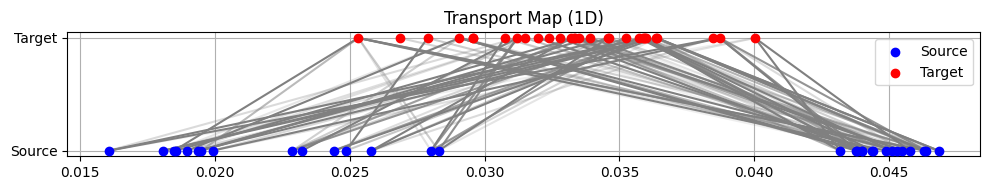

In [13]:
visualize_transport_1d(c, r, np.array(P))

We can notice that even with constraints, we reach a solution proving the theoretical proofs claimed by the article. 